In [1]:
import numpy as np
import pandas as pd
import data_lib
import plot_lib
import decision_lib
from sklearn import cluster
import validation_lib
import transform_lib
from icecream import ic
import stats_lib

np.random.seed(200)

In [2]:
# print available data summary
_ = data_lib.explore_datasets(datafolder="../../Data",verbose=True)
print(data_lib.LABELS_LIST)

----------------------------------------------------------------------------------------------
-- The following 4 groups were found
-- They contain 40 datasets
-- The first printed entity is the key to the returned dictionary
-----------------------------------
Group: ../../Data/6P-positive-dilution-series-2-labelled/droplet-level-data/RawData
po-di-se-2-A4, files: 13                po-di-se-2-C4, files: 13                po-di-se-2-A1, files: 13
po-di-se-2-B1, files: 13                po-di-se-2-D1, files: 13                po-di-se-2-B4, files: 13
po-di-se-2-C1, files: 13                po-di-se-2-D4, files: 13                
-----------------------------------
Group: ../../Data/6P-positive-dilution-series-1-labelled/droplet-level-data/RawData
po-di-se-1-D4, files: 13                po-di-se-1-A4, files: 13                po-di-se-1-A1, files: 13
po-di-se-1-D1, files: 13                po-di-se-1-B1, files: 13                po-di-se-1-C1, files: 13
po-di-se-1-B4, files: 13         

### Get samples for negative control

In [3]:

# compute transformation on waste water
df_wa = data_lib.load_dataset(None, [
                                    # probelmatic dimension 3
                                     "wa-sa-B3",  
                                     "wa-sa-A2", 
                                     "wa-sa-B2", 
                                     "wa-sa-A3",
                                     "wa-sa-A1", 
                                     "wa-sa-B1", 
                                     
                                     #"wa-sa-D2",
                                     #"wa-sa-D1",
                                     #"wa-sa-C2",

                                     #"wa-sa-B4",
                                     #"wa-sa-C4",
                                     #"wa-sa-A4",

                                     #"wa-sa-A5", 
                                     #"wa-sa-C3", # Pos
                                     #"wa-sa-D3", # Zero
                                     #"wa-sa-D4", 
                                     #"wa-sa-C5", # Pos
                                     #"wa-sa-D5", # Zero
                                     #"wa-sa-C1",
                                     ], datafolder="../../Data")
df_negative_control = data_lib.load_dataset([],[
                                                "wa-sa-D3",
                                                "wa-sa-D5"
                                                ], datafolder="../../Data")
np_negative_control = df_negative_control.to_numpy()
np_wa = df_wa.to_numpy(copy=True)[:,:6]


In [4]:
# fix clustering algorithm
prediction_axis = ['SARS-N2_POS','SARS-N1_POS','IBV-M_POS','RSV-N_POS','IAV-M_POS','MHV_POS']
#cluster_engine = cluster.DBSCAN(eps=700, min_samples=5)
whitening_engine = transform_lib.WhitenTransformer(whiten=transform_lib.Whitenings.NONE)
num_cluster = int(2**len(prediction_axis) * 2)
cluster_engine = cluster.KMeans(n_clusters=num_cluster, n_init='auto')
decision = decision_lib.WhitnesDensityClassifier(
                                     negative_control=np_negative_control,
                                     cluster_algorithm=cluster_engine,
                                     whitening_transformer=whitening_engine,
                                     negative_range=0.2,
                                     eps=0.45,
                                     outlier_quantile=0.001,
                                     prediction_axis=prediction_axis,
                                     verbose=True
                                     )
df_decision = decision.predict(np_wa, verbose=1)

Finished compute clusters in 0.457172155380249 seconds
Finished compute transformed features in 0.15590763092041016 seconds
Finished predict cluster labels in 0.6516907215118408 seconds
Finished predict labels in 0.024771690368652344 seconds


/home/nico/edu/semiv/lab/code/libs/decision_lib/whitnes_density_classifier.py:296: RuntimeWarning: overflow encountered in exp
  in_range = 1 / (1 + np.exp(scaled_avg_dist_))


all_data: array([580649.61363481, 567201.03343863, 519810.41037185, 775454.94531809, 629424.8984976 , 626092.23288712])
zero_cluster: array([4552.02708072, 4057.98121764, 3611.95697644, 4519.02878668, 1311.93240028, 3594.29422528]

## Plot the predictions

- Black = True negative prediction
- Green = True positive prediciton
- Purple = False negative
- Red = False positive

#### Plot for all diseases predictions against ground truth

Firs plot is in the decorrelated coordinates, whereas the second is in original coordinates

Outlier rate: 0.0010114216641586699, n_outlier: 41

Total error rate: 0.02972195698510696
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.042593      0.03899   0.046985   0.011299   0.025305  0.01316

Precision (TP / (TP + FP)): 0.9978167219220999
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.998885     0.999599   0.985947   0.999539        1.0      1.0

Recall / TPR (TP / (TP + FN)): 0.9972656950462214
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
         1.0     0.998655    0.99683        1.0   0.992072      1.0

Specificity / TNR (TN / (TN + FP)): 0.999905557577072
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999923     0.999978    0.99954   0.999985        1.0      1.0

Accuracy ((TP + TN) / (P + N)): 0.9997960214372325
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999928     0.999909   0.999455   0.999986   0.999489      1.0

F1 (2 * (precision * re

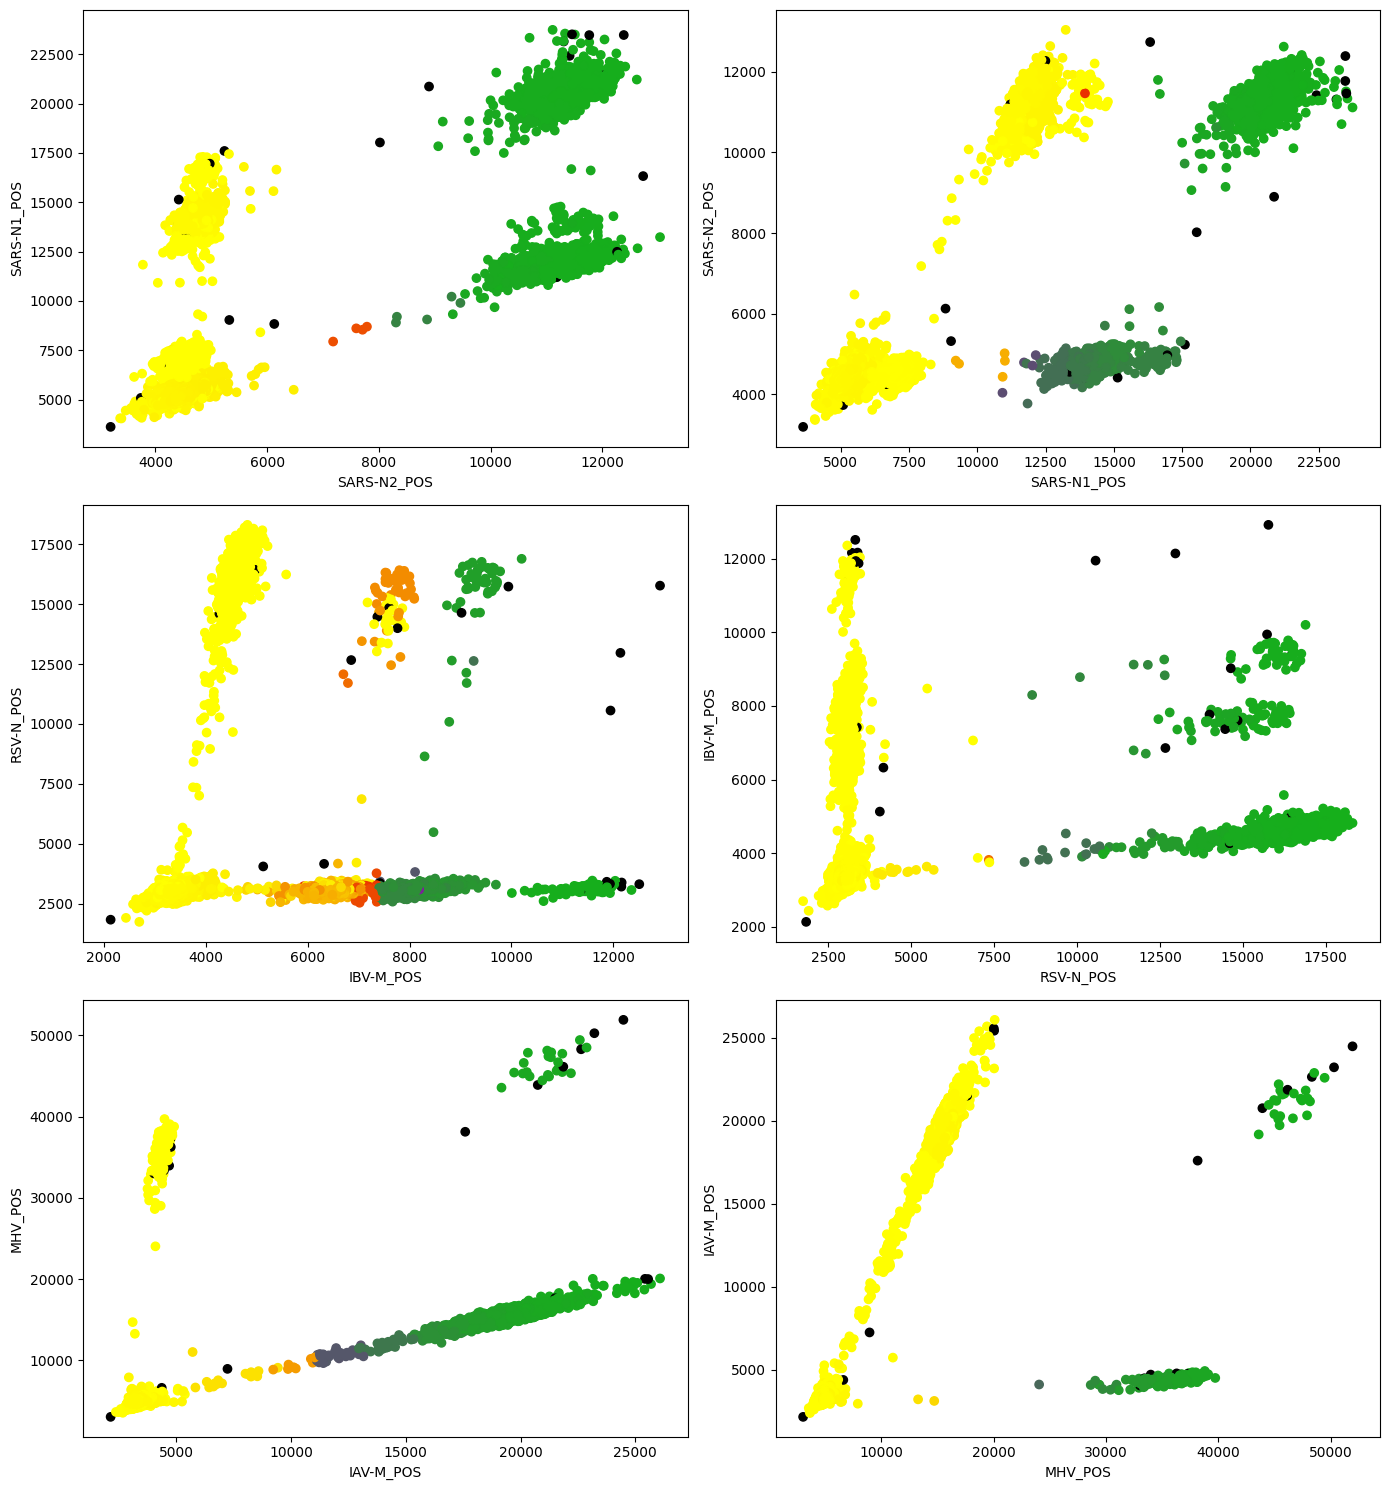

In [5]:

df_data_points = pd.DataFrame(data=decision.X, columns=prediction_axis) 
df_predictions = decision.probabilities_df
df_ground_trouth = df_wa
selected_pairs = [
                ('SARS-N2_POS','SARS-N1_POS'),
                ('SARS-N1_POS','SARS-N2_POS'),
                ('IBV-M_POS','RSV-N_POS'),
                ('RSV-N_POS','IBV-M_POS'),
                ('IAV-M_POS','MHV_POS'),
                ('MHV_POS','IAV-M_POS'),
                ]

validation_lib.validate_labels(df_ground_trouth, df_predictions, threshold=0.5)

df_result = stats_lib.compute_results(df_predictions, 0.40, 0.60, df_data_points)

plot_lib.plot_pairwise_selection_bayesian(
        df_data_points,
        df_predictions,
        df_ground_trouth,
        selected_pairs,
        n_cols=2,
        mask=decision.No_neg_mask
        )

In [6]:
validation_lib.get_negative_percent(df_ground_trouth, prediction_axis)

ic| negative_count.shape: (6,)
ic| negative_percent.shape: (6,)
ic| axis: ['SARS-N2_POS', 'SARS-N1_POS', 'IBV-M_POS', 'RSV-N_POS', 'IAV-M_POS', 'MHV_POS']
ic| all_neg.shape: ()
ic| all_neg_per.shape: ()
ic| np.var(np_points, axis=0): array([0.05927173, 0.06103449, 0.03659233, 0.03076389, 0.06457795,
                                      0.0080259 ])


Positive count: 
   SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
0         2565         2647       1542       1288       2813      328
Positive percent: 
   SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS   MHV_POS
0     0.063276     0.065298   0.038039   0.031773   0.069393  0.008091
Negative percent: 
   SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS   MHV_POS
0     0.936724     0.934702   0.961961   0.968227   0.930607  0.991909
All neg Count count: 
31124
All neg percent: 
0.7677923872018156
All pos percent: 
0.23220761279818436


In [7]:
decision.neg_dimensions

array([False, False, False, False, False, False])